In [1]:
%cd /home/ubuntu/Qwen-Image-Edit-Angles

/home/ubuntu/Qwen-Image-Edit-Angles


In [2]:
import pandas as pd
from matplotlib import pyplot as plt

In [8]:
from qwenimage.experiment import ExperimentConfig
from qwenimage.experiments.experiments_qwen import ExperimentRegistry


# experiment_names = ExperimentRegistry.keys()
experiment_names = [
    "qwen_base",
    "qwen_fa3",
    "qwen_aot",
    "qwen_fa3_aot",
    "qwen_fa3_aot_int8",
    "qwen_fa3_aot_fp8",
    "qwen_fa3_fuse",
]

report_dir = ExperimentConfig().report_dir

all_results = []
for name in experiment_names:
    csv_path = report_dir / f"{name}.csv"
    
    df = pd.read_csv(csv_path, index_col=0)
    df['experiment'] = name
    all_results.append(df)
    print(f"Loaded results for {name}: {len(df)} rows")



Loaded results for qwen_base: 17 rows
Loaded results for qwen_fa3: 17 rows
Loaded results for qwen_aot: 18 rows
Loaded results for qwen_fa3_aot: 18 rows
Loaded results for qwen_fa3_aot_int8: 18 rows
Loaded results for qwen_fa3_aot_fp8: 18 rows
Loaded results for qwen_fa3_fuse: 18 rows


In [9]:
all_results[0]

,name,mean,std,len,experiment
0,QwenBaseExperiment.load,21.185231,0.000000,1,qwen_base
1,QwenBaseExperiment.optimize,0.000001,0.000000,1,qwen_base
2,Preprocessing,0.039617,0.003496,32,qwen_base
3,QwenImageEditPlusPipeline.encode_prompt,0.098163,0.035044,32,qwen_base
4,Encode Prompt,0.098201,0.035047,32,qwen_base
5,QwenImageEditPlusPipeline._encode_vae_image,0.079450,0.019298,32,qwen_base
6,Prep gen,0.081286,0.019624,32,qwen_base
7,loop 0,0.385146,0.017718,32,qwen_base
8,loop 1,0.448298,0.018052,32,qwen_base
9,loop 2,0.464333,0.009766,32,qwen_base


In [10]:
combined_df = pd.concat(all_results, ignore_index=True)
print(f"{combined_df.shape=}")
print(f"{combined_df.columns.tolist()=}")
combined_df.head(5)

combined_df.shape=(124, 5)
combined_df.columns.tolist()=['name', 'mean', 'std', 'len', 'experiment']


,name,mean,std,len,experiment
0,QwenBaseExperiment.load,21.185231,0.000000,1,qwen_base
1,QwenBaseExperiment.optimize,0.000001,0.000000,1,qwen_base
2,Preprocessing,0.039617,0.003496,32,qwen_base
3,QwenImageEditPlusPipeline.encode_prompt,0.098163,0.035044,32,qwen_base
4,Encode Prompt,0.098201,0.035047,32,qwen_base


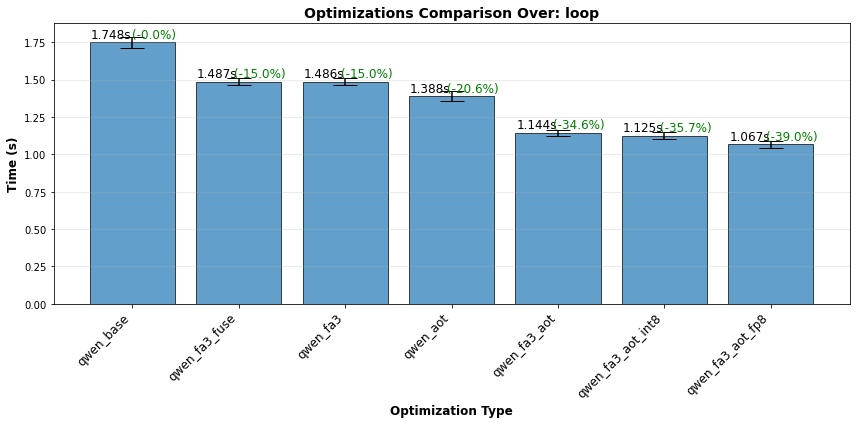

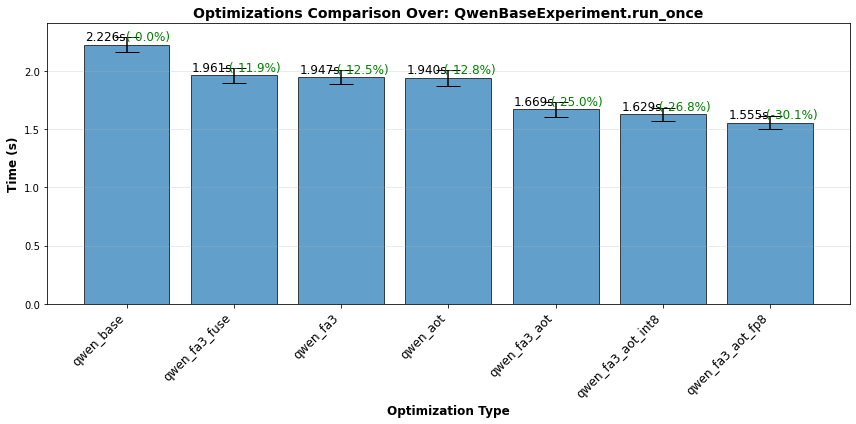

In [11]:
profile_targets = ["loop", "QwenBaseExperiment.run_once"]

for target in profile_targets:
    plot_data = combined_df[combined_df['name'] == target].copy()
    plot_data = plot_data.sort_values('mean', ascending=False)

    fig, ax = plt.subplots(figsize=(12, 6))
    x_pos = range(len(plot_data))
    max_time = plot_data['mean'].max()

    bars = ax.bar(x_pos, plot_data['mean'], yerr=plot_data['std'], 
                    capsize=12, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Optimization Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Time (s)', fontsize=12, fontweight='bold')
    ax.set_title(f'Optimizations Comparison Over: {target}', 
                    fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([row['experiment'] for _, row in plot_data.iterrows()], 
                        rotation=45, ha='right', fontsize=12)
    ax.grid(axis='y', alpha=0.3)


    for i, (idx, row) in enumerate(plot_data.iterrows()):        
        ax.text(i - 0.2, row['mean'] + 0.01, f"{row['mean']:.3f}s", 
                ha='center', va='bottom', fontsize=12)
        
        pct_decrease = ((max_time - row['mean']) / max_time) * 100
        ax.text(i + 0.2, row['mean'] + 0.01, f"(-{pct_decrease:.1f}%)", 
                ha='center', va='bottom', fontsize=12, color='green')
    
    

    plt.tight_layout()

    plot_path = report_dir / f'{target}_performance_comparison.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')

    plt.show()


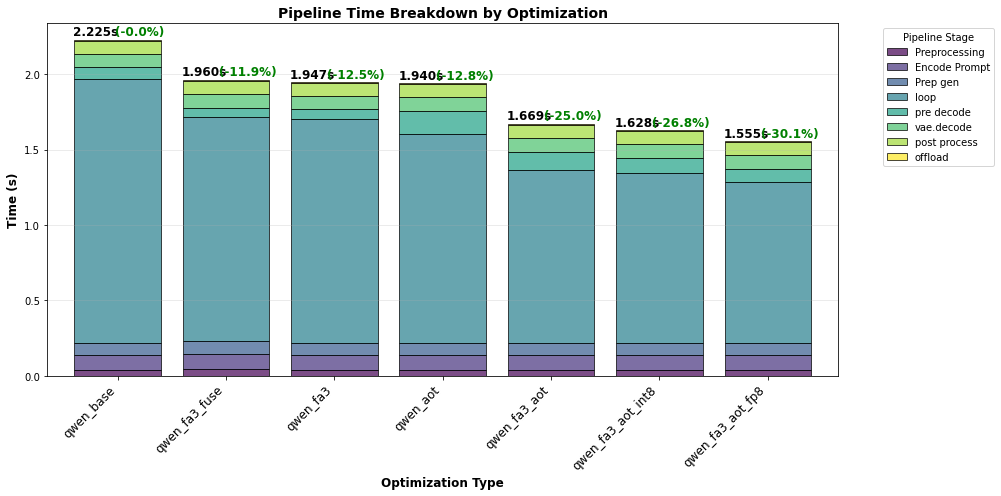

In [12]:
stack_targets = ["Preprocessing", "Encode Prompt", "Prep gen", "loop", "pre decode", "vae.decode", "post process", "offload"]


stack_data = combined_df[combined_df['name'].isin(stack_targets)].copy()
pivot_data = stack_data.pivot(index='experiment', columns='name', values='mean')
pivot_data = pivot_data[stack_targets]
pivot_data['total'] = pivot_data.sum(axis=1)
pivot_data = pivot_data.sort_values('total', ascending=False)
pivot_data = pivot_data.drop('total', axis=1)


fig, ax = plt.subplots(figsize=(14, 7))
pivot_data.plot(kind='bar', stacked=True, ax=ax, 
                colormap='viridis', edgecolor='black', capsize=12, alpha=0.7, width=0.8)


ax.set_xlabel('Optimization Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Time (s)', fontsize=12, fontweight='bold')
ax.set_title('Pipeline Time Breakdown by Optimization', 
             fontsize=14, fontweight='bold')
ax.set_xticklabels(pivot_data.index, rotation=45, ha='right', fontsize=12)
ax.legend(title='Pipeline Stage', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3)

max_time = pivot_data.sum(axis=1).max()
for i, (idx, row) in enumerate(pivot_data.iterrows()):
    total = row.sum()
    
    ax.text(i - 0.2, total + 0.01, f'{total:.3f}s', 
            ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    pct_decrease = ((max_time - total) / max_time) * 100
    ax.text(i + 0.2, total + 0.01, f'(-{pct_decrease:.1f}%)', 
            ha='center', va='bottom', fontsize=12, color='green', fontweight='bold')

plt.tight_layout()

plot_path = report_dir / 'stacked_time_breakdown.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

plt.show()
